In [315]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 載入載原始資料

* `ratings`: 使用者評論資料
* `metadata`: 商品資料

In [336]:
all_beauty_path = 'data/All_Beauty.csv'
ratings = pd.read_csv(
    all_beauty_path,
    names=["asin", "reviewerID", "overall", "unixReviewTime"],
    dtype={"asin": np.str_, "reviewerID": np.str_, "overall": np.float32, "unixReviewTime": np.float64 }
)
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')
ratings.head()

,asin,reviewerID,overall,unixReviewTime,DATE
0,0143026860,A1V6B6TNIC10QE,1.0,1.424304e+09,2015-02-19
1,0143026860,A2F5GHSXFQ0W6J,4.0,1.418861e+09,2014-12-18
2,0143026860,A1572GUYS7DGSR,4.0,1.407629e+09,2014-08-10
3,0143026860,A1PSGLFK1NSVO,5.0,1.362960e+09,2013-03-11
4,0143026860,A6IKXKZMTKGSC,5.0,1.324771e+09,2011-12-25


In [337]:
meta_all_beauty_path = 'data/meta_All_Beauty.json.gz'
metadata = pd.read_json(
    meta_all_beauty_path,
    lines=True,
    compression="gzip"
)
metadata.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


# 準備訓練和測試資料
* `ratings_trainings`: 準備訓練
* `ratings_testings`: 測試資料

In [338]:
# 真實被購買的商品資料（2018-09-01 以前資料）
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]

# 真實被購買的商品資料（2018-09-01 - 2018-09-30 的資料）
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') &
    (ratings['DATE'] <= '2018-09-30')
]

# 準備使用者清單
`users`: 使用者清單

In [344]:
# userID -> asin list
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }

# userID list
users = list(ratings_testings_by_user.keys())
users[0:4]

['A100XQFWKQ30O2', 'A103T1QOGFCSEH', 'A106UKKSJ2KXPF', 'A10A7GV4D5A11V']

# 分析品牌次數分佈

## 分析品牌頻次的統計分析
* `user_brand_meta`：品牌頻次的統計分析

In [410]:
def compute_user_brand_meta(training_data, metadata):
    # 計算使用者已購買過的品牌
    ratings_trainings_with_meta = training_data.merge(metadata, left_on='asin', right_on='asin')
    user_brand_size = ratings_trainings_with_meta.groupby(['reviewerID', 'brand']).size()

    # 品牌頻次統計
    user_brand_meta = user_brand_size.groupby(level=0).agg([list, 'size', 'sum', 'mean', 'std'])
    user_brand_meta = user_brand_meta.sort_values(by=['size'], ascending=False)

    # 標準化頻次
    def normalize(row):
        return [elt/row['sum'] for elt in row['list']]
    user_brand_meta['list_normal'] = user_brand_meta.apply(lambda row: normalize(row), axis=1)

    # 計算 list_normal_std
    def list_std(row):
        return np.std(row['list_normal'])
    user_brand_meta['list_normal_std'] = user_brand_meta.apply(lambda row: list_std(row), axis=1)

    user_brand_meta = user_brand_meta.sort_values(by='list_normal_std', ascending=False)
    return user_brand_meta
user_brand_meta_df = compute_user_brand_meta(ratings_trainings, metadata)
user_brand_meta_df.head()

## 觀察 list_normal_std 的分佈

In [406]:
# 觀察 list_normal_std 的分佈
normal_std_list = user_brand_meta_df['list_normal_std']
bin_size = 10
step = (normal_std_list.max() - normal_std_list.min())/bin_size
bins = [normal_std_list.min() + x * step for x in range(0, bin_size + 2)]
print('min - max: %s - %s' % (normal_std_list.min(), normal_std_list.max()))

hist, bin_edges = np.histogram(list(normal_std_list), bins=bins)
for i in range(len(hist)):
    print('[%s , %s) => %s' % (bins[i], bins[i+1], hist[i]))

min - max: 0.0 - 0.42307692307692313
[0.0 , 0.04230769230769231) => 314246
[0.04230769230769231 , 0.08461538461538462) => 710
[0.08461538461538462 , 0.12692307692307692) => 1155
[0.12692307692307692 , 0.16923076923076924) => 2219
[0.16923076923076924 , 0.21153846153846156) => 76
[0.21153846153846156 , 0.25384615384615383) => 297
[0.25384615384615383 , 0.29615384615384616) => 8
[0.29615384615384616 , 0.3384615384615385) => 63
[0.3384615384615385 , 0.3807692307692308) => 9
[0.3807692307692308 , 0.42307692307692313) => 1
[0.42307692307692313 , 0.4653846153846154) => 2


策略： `list_normal_std` < `0.0423` 的人都推同一個品牌，否則就不同品牌


## 品牌數量的分佈
我們來看看品牌數的分佈

In [407]:
brand_freq = user_brand_meta_df.groupby(by='size').size()
print('#(品牌數=1): %s 人\n#(品牌數>1): %s人\n' % (brand_freq[1], brand_freq.sum() - brand_freq[1]))
print('(品牌數>1) 的佔比: %s %%\n' % ((1.0 - brand_freq[1]/brand_freq.sum()) * 100))

#(品牌數=1): 302890 人
#(品牌數>1): 15896人

(品牌數>1) 的佔比: 4.986417220329631 %



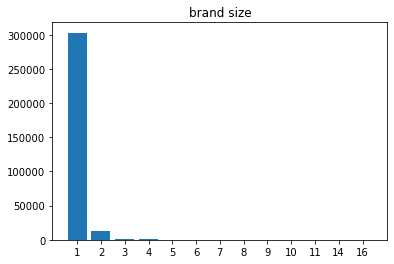

In [408]:
# 分佈直條圖
left = np.array(brand_freq.index)
height = brand_freq.values
fig = plt.figure()
fig.patch.set_facecolor('xkcd:white')
plt.bar(range(0, left.size), height, tick_label=[str(s) for s in left])
# plt.yscale('log')
plt.title('brand size')
plt.show()

## 分析結論
依品依頻次來看，所有 318786 人只有 15896 有兩個品牌以上。因此可以預期若單純用到"品牌統計結果"的策略，可能會影響到的人數會很少。

# 產生推薦結果

利用切分好的訓練資料（也就是最後一個月以前的資料）用來學習模式，產生「最後一個月推薦給使用者的商品」作為我們預測的推薦資料。
在這個過程中，會指定輸入的資料會包含：

* 訓練資料(`ratings_trainings`, `metadata`)：歷史行為與商品資訊（All_Beauty.csv / meta_All_Beauty.json.gz）
* 使用者列表(`users`)：需要被推薦的使用者清單
* Top-K：每一個使用者需要推薦幾個商品數

而最後需要輸出的資料是「需要被推薦的使用者分別推薦哪 k 個商品」

# 推薦
原理購買品牌的分散程度，來決定是否是推薦同品牌還是不同品牌

```
同品牌的頃向 = 購買比例的標準差
```

In [416]:
# 注：額外需要 metadata
def recommender(training_data, user_ids=[], k=10):
    """
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    """
    ratings_trainings_with_meta = training_data.merge(metadata, left_on='asin', right_on='asin')
    user_brand_meta_stats = compute_user_brand_meta(training_data, metadata)

    # 依 threshold 分成兩群
    # 對於 lt_threshold_user_ids 的人 -> 推薦同品牌
    # 對於 gte_threshold_user_ids 的人 -> 推薦不同品牌，除了已買的
    threshold = 0.0423
    user_brand_meta_lt_threshold = user_brand_meta_stats[user_brand_meta_stats['list_normal_std'] < threshold]
    user_brand_meta_gte_threshold = user_brand_meta_stats[user_brand_meta_stats['list_normal_std'] >= threshold]

    lt_threshold_user_ids = user_brand_meta_lt_threshold.index.tolist()
    gte_threshold_user_ids = user_brand_meta_gte_threshold.index.tolist()

    # 過去購買的品牌
    ratings_trainings_with_brands = ratings_trainings_with_meta[['reviewerID', 'brand']].groupby(['reviewerID']).agg(list)
    user_to_brands = { user_id: ratings_trainings_with_brands['brand'][user_id] for user_id in ratings_trainings_with_brands.index }

    # 計算
    recommendations = {}
    count_no_brands = 0
    count_same_brands = 0
    count_not_same_brands = 0
    count_default_brands = 0

    for user in user_ids:
        if user not in user_to_brands:
            # 沒有過去購買紀錄的人，default: 從過去的購買清單選
            count_no_brands += 1
            recommendations[user] = ratings_trainings_with_meta['asin'].sample(n=k).tolist()
        else:
            bought_brands = user_to_brands[user]
            if user in lt_threshold_user_ids:
                # 推薦同品牌
                count_same_brands += 1
                rec_list = ratings_trainings_with_meta[ratings_trainings_with_meta['brand'].isin(bought_brands)]['asin']
                take_n = np.min([k, len(rec_list)])
                recommendations[user] = rec_list.sample(n=take_n).tolist()
                # 不夠的，從過去的購買清單選
                if (k - take_n) > 0:
                    recommendations[user] += ratings_trainings_with_meta[~ratings_trainings_with_meta['brand'].isin(bought_brands)]['asin'].sample(n=k - take_n).tolist()
            elif user in gte_threshold_user_ids:
                # 推薦不同品牌，除了已買的
                count_not_same_brands += 1
                rec_list = ratings_trainings_with_meta[~ratings_trainings_with_meta['brand'].isin(bought_brands)]['asin']
                recommendations[user] = rec_list.sample(n=np.min([k, len(rec_list)])).tolist()
            else:
                # 沒有品牌，隨意
                count_default_brands += 1
                recommendations[user] = ratings_trainings_with_meta['asin'].sample(n=k).tolist()
    print('count_no_brands: %s\ncount_same_brands: %s\ncount_not_same_brands: %s\ncount_default_brands: %s' % (count_no_brands, count_same_brands, count_not_same_brands, count_default_brands))
    return recommendations

In [417]:
ratings_by_user = recommender(ratings_trainings, users)

count_no_brands: 546
count_same_brands: 38
count_not_same_brands: 0
count_default_brands: 0


{'A100XQFWKQ30O2': ['B0002W30IA',
  'B00EEE5W4W',
  'B000X2FPXC',
  'B015X8MFFG',
  'B01C64NSTM',
  'B00005JS5C',
  'B00F58ERR4',
  'B003983HRI',
  'B000FOI48G',
  'B00VF344X0'],
 'A103T1QOGFCSEH': ['B019LBMXBM',
  'B00XPJ02ZQ',
  'B00021DJ32',
  'B01C64NS2O',
  'B00VL87Q8E',
  'B00I0D44D8',
  'B004BS09WG',
  'B016N4667C',
  'B00VB5N3X4',
  'B00BJLPSU6'],
 'A106UKKSJ2KXPF': ['B00L0JYAZG',
  'B00GW51XFS',
  'B00MGAJ5GM',
  'B007QG7G3U',
  'B00NNLKABW',
  'B00028ORTK',
  'B0014T8HKQ',
  'B01B54XW54',
  'B013WHRX7K',
  'B00D3M0CRS'],
 'A10A7GV4D5A11V': ['B00399D3Y4',
  'B014PRF6UW',
  'B000FOI48G',
  'B01E1RQ27M',
  'B00L1I1VMG',
  'B000GLRREU',
  'B00VF344X0',
  'B000VYOPTW',
  'B01DQL0FUY',
  'B006JZ0IRA'],
 'A1119JJ37ZLB8R': ['B00006L9LC',
  'B001EUCERC',
  'B00005JS5C',
  'B000FOI48G',
  'B00RFE2W5A',
  'B000EG8HLE',
  'B00NS8YA98',
  'B00L5HZCPU',
  'B000JV2Y0O',
  'B01CJ9AIG0'],
 'A113UOOLBSZN52': ['B00TE2M7II',
  'B00020UR4C',
  'B01B54XW54',
  'B000H6A02A',
  'B0010ZBORW',
  'B001

# Recall 結果評估

In [418]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    """
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    """
    total = 0
    for user_id in ratings_testings_by_user:
        if user_id in ratings_by_user: # 只計對有購買者
            total += len(set(ratings_by_user[user_id]) & set(ratings_testings_by_user[user_id]))
    score = total / len(ratings_testings)
    return score
evaluate(ratings_testings_by_user, ratings_by_user)


0.010169491525423728